In [44]:
import image
import os
import random
import numpy as np
import scipy as sp
from sklearn import linear_model

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib import cm
figsize(16, 8)

In [2]:
imdir = "images/raw"
handles = os.listdir(imdir)
random.shuffle(handles)

In [59]:
def ShowColorAndGreyscale(color, grey):
    _, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(color)
    ax2.imshow(grey, cmap=cm.gray)
    plt.show()

    
def ShowChannels(color, grey):
    _, axes = plt.subplots(1, 3)
    for ch in xrange(color.shape[2]):
        ax = axes[ch]
        ax.imshow(color[:, :, ch:ch + 1].reshape(
            grey.shape), cmap=cm.gray)
    plt.show()


def ModelChannels(color, grey, stride,
                  clf_class=linear_model.LinearRegression, clf_kwargs={}):
    ymax, xmax = grey.shape
    stepmin, stepmax = ((stride - 1) / -2, stride / 2)
    steps = range(stepmin, stepmax + 1)
    trimmed_shape = (ymax - 2 * stepmax, xmax - 2 * stepmax)
    
    # convolutional patches for training
    # there's probably a numpy one-liner for this, but I don't know it
    patches = []
    for xoff in steps:
        for yoff in steps:
            patches.append(
                grey[stepmax + yoff:ymax - stepmax + yoff,
                     stepmax + xoff:xmax - stepmax + xoff])
    patches = np.stack(patches, axis=2)
    train_features = patches.reshape(
        np.product(trimmed_shape), len(steps) ** 2)
    plt.imshow(patches.mean(axis=2), cmap=cm.gray)
    plt.show()
    
    # models for each channel
    ch_clfs = []
    for ch in xrange(color.shape[2]):
        target_luminosities = color[
            stepmax:ymax - stepmax,
            stepmax:xmax - stepmax,
            ch].reshape(np.product(trimmed_shape))
        clf = clf_class(**clf_kwargs)
        clf.fit(train_features, target_luminosities)
        ch_clfs.append(clf)
    
    # restore original image
    channels = []
    for clf in ch_clfs:
        channels.append(clf.predict(train_features).reshape(*trimmed_shape))
    restored = np.stack(channels, axis=2)
    plt.imshow(restored)
    print restored
    
    return ch_clfs


def ProcessImage(i, stride=3):
    color, grey = image.LoadColorAndGreyscaleImages(
        os.path.join(imdir, handles[i]))
    ShowColorAndGreyscale(color, grey)
    ShowChannels(color, grey)
    ch_clfs = ModelChannels(color, grey, stride)
    return ch_clfs


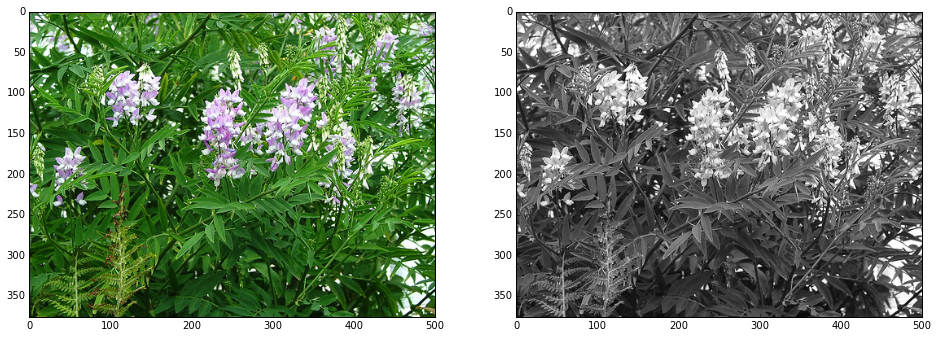

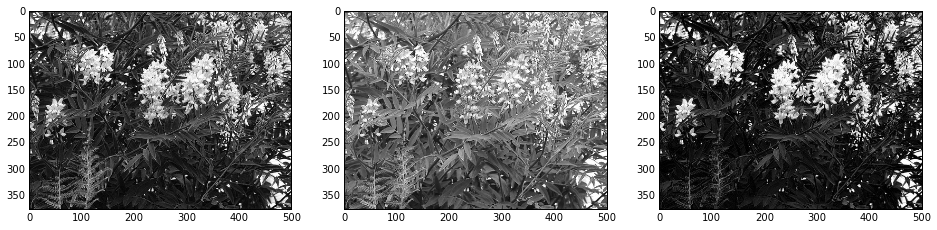

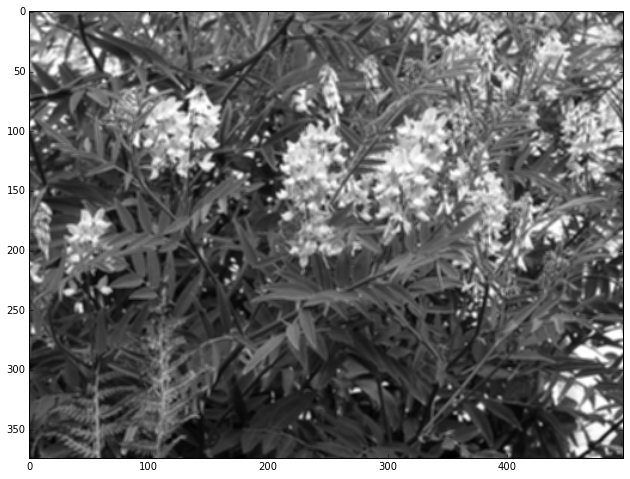

[[[  33.45969992   82.85743811   13.76885553]
  [  30.2492892    79.43563752   10.96629155]
  [  34.51796859   82.86791304   16.18489352]
  ..., 
  [  95.50625262  135.35418026   76.08896699]
  [  93.45091783  133.81642848   73.65218828]
  [ 106.46436141  147.5041892    84.54924371]]

 [[  35.88845311   82.21184982   17.19659007]
  [  44.84731827   89.81128361   25.89332943]
  [  62.16015437  106.64830951   42.96466286]
  ..., 
  [ 105.65075694  146.05904024   88.13313295]
  [  98.23853302  136.27760185   81.41348465]
  [  76.92445221  115.92812929   60.17710015]]

 [[ 100.06262095  141.44568624   78.9655519 ]
  [ 105.71835499  145.63165842   84.86703406]
  [  86.32855958  126.66097991   67.26470647]
  ..., 
  [  81.92971772  122.82457052   65.994772  ]
  [ 103.14081664  139.78299357   86.65518833]
  [  91.58134781  127.82713345   74.93916753]]

 ..., 
 [[  -8.23732109   48.14292291  -29.95195069]
  [  -8.76567975   47.49270564  -26.59531388]
  [  86.6413907   135.52598282   64.3586613

[LinearRegression(copy_X=True, fit_intercept=True, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, normalize=False)]

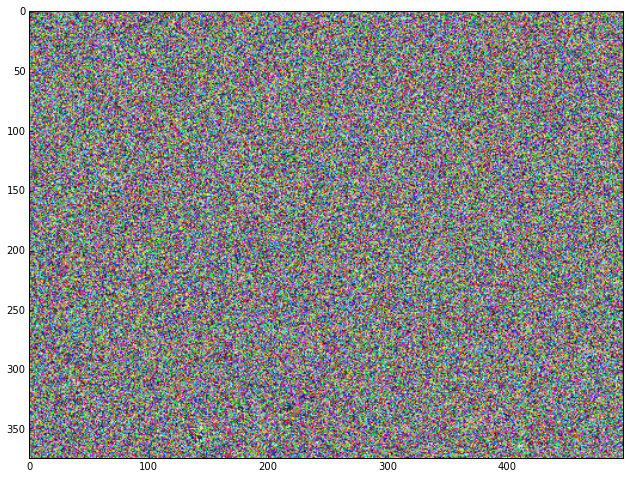

In [60]:
ProcessImage(88, stride=3)